In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
import glob
from sklearn.model_selection import GridSearchCV

In [3]:
folder_path = 'datasets/data-transformed'
json_files = glob.glob(f'{folder_path}/*.json.gz')
posts = pd.concat((pd.read_json(f, compression='gzip', lines=True) for f in json_files))

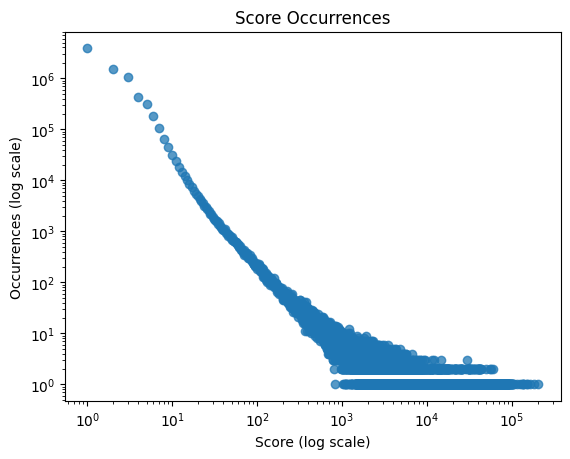

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each score
score_counts = posts['score'].value_counts().sort_index()

# Plot the data with a log scale on both axes
plt.scatter(score_counts.index, score_counts.values, alpha=0.75)
plt.xscale('log')
plt.yscale('log')
plt.title('Score Occurrences')
plt.xlabel('Score (log scale)')
plt.ylabel('Occurrences (log scale)')
plt.show()

In [5]:
# Select features and target variable
features = posts[['age_when_retrieved', 'year', 'month', 'day', 'hour', 'day_of_week', 'post_count', 'over_18', 'gilded', 'archived', 'quarantine', 'stickied', 'num_comments', 'title_length']]
target = posts['score']

def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f"{model_name} Model:")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")
    print(f"RMSE: {rmse}\n")
    
    return {'Model': model_name, 'MAE': mae, 'R^2': r2, 'RMSE': rmse}


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# for the random forest regression model, I'm using the hyperparemeters used here: https://towardsdatascience.com/predicting-reddit-comment-karma-a8f570b544fc as I do not have sufficient
# resources to find the optimal hyperaparmeters (limited computing power)

In [7]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_results = evaluate_model(linear_model, X_test, y_test, 'Linear Regression')


Linear Regression Model:
MAE: 23.678504841968014
R^2: 0.7117533053235096
RMSE: 402.17307641043215



In [8]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 42)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, X_test, y_test, 'Random Forest')


Random Forest Model:
MAE: 8.364836517768577
R^2: 0.8195549541053592
RMSE: 318.2022944068193



In [9]:
# KNN Regression
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_results = evaluate_model(knn_model, X_test, y_test, 'KNN')

KNN Model:
MAE: 10.47529904168376
R^2: 0.6880863036514613
RMSE: 418.35797093429835



In [10]:
# Decision Tree Regression

# Further hyper parameter tuning can be done
param_grid = {
    'min_samples_split': [50, 60, 70],
    'min_samples_leaf': [50, 60, 70],
}

dt_model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_

dt_results = evaluate_model(best_dt_model, X_test, y_test, 'Decision Tree')
print("Best Hyperparameters:", grid_search.best_params_)

# min_samples_split=30, min_samples_leaf=10
# MAE: 9.169568055255125
# R^2: 0.7815482514542809
# RMSE: 350.11328307234595

# min_samples_split=45, min_samples_leaf=45
# MAE: 8.629404693557964
# R^2: 0.805199737410973
# RMSE: 330.61731476948245

# min_samples_split=60, min_samples_leaf=60
# MAE: 8.629277525852446
# R^2: 0.8028147199163463
# RMSE: 332.63509741052724

# min_samples_split=100, min_samples_leaf=100
# MAE: 8.703126249850408
# R^2: 0.8021441882072129
# RMSE: 333.20018291590077



Decision Tree Model:
MAE: 8.587629477598373
R^2: 0.8051930291446991
RMSE: 330.623007394993

Best Hyperparameters: {'min_samples_leaf': 50, 'min_samples_split': 50}


In [11]:
# Baseline Model: Median
median_predictions = DummyRegressor(strategy='median')
median_predictions.fit(X_train, y_train)
median_results = evaluate_model(median_predictions, X_test, y_test, 'Baseline (Median)')

# Baseline Model: Mean
mean_predictions = DummyRegressor(strategy='mean')
mean_predictions.fit(X_train, y_train)
mean_results = evaluate_model(mean_predictions, X_test, y_test, 'Baseline (Mean)')

Baseline (Median) Model:
MAE: 18.54108049118893
R^2: -0.0005989588506338794
RMSE: 749.3088268678878

Baseline (Mean) Model:
MAE: 34.99604013960664
R^2: -1.6310135459995934e-06
RMSE: 749.0851359299301



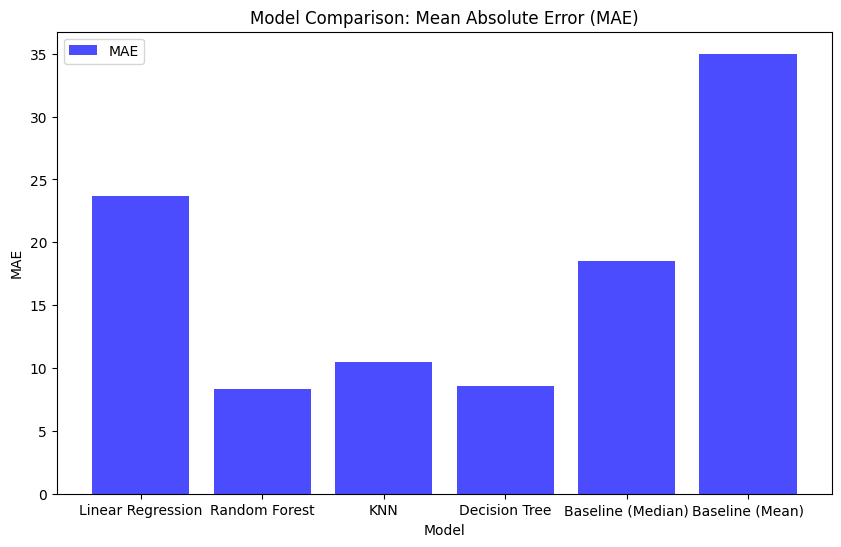

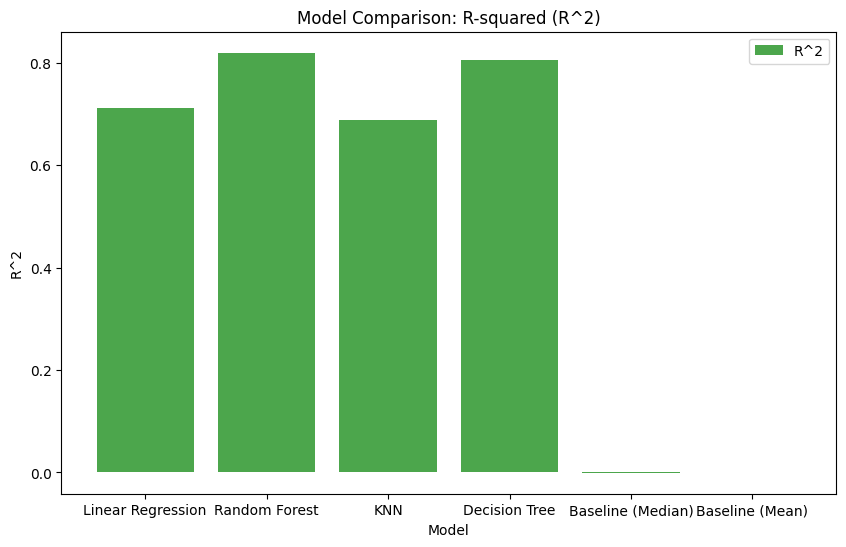

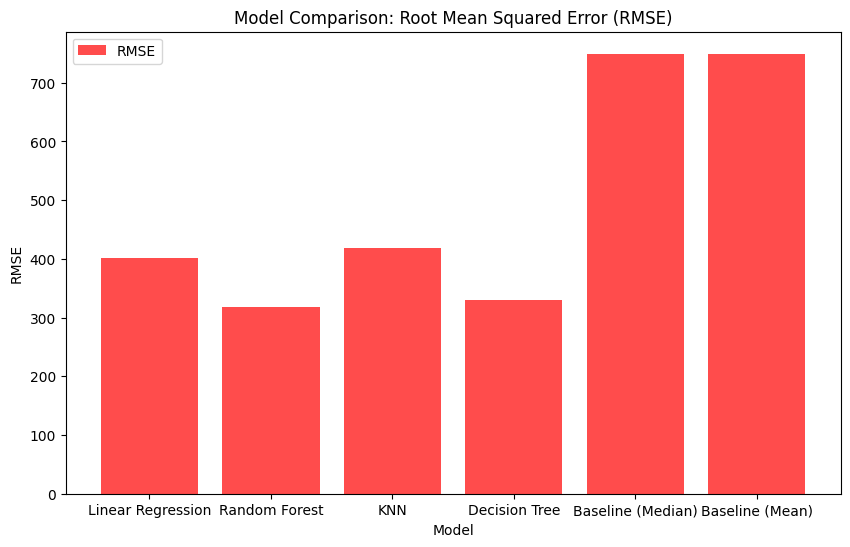

In [12]:
results = pd.DataFrame([linear_results, rf_results, knn_results, dt_results, median_results, mean_results])
models = results['Model']
mae_values = results['MAE']
r2_values = results['R^2']
rmse_values = results['RMSE']

# Plotting MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='blue', alpha=0.7, label='MAE')
plt.title('Model Comparison: Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plotting R^2
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='green', alpha=0.7, label='R^2')
plt.title('Model Comparison: R-squared (R^2)')
plt.xlabel('Model')
plt.ylabel('R^2')
plt.legend()
plt.show()

# Plotting RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='red', alpha=0.7, label='RMSE')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.legend()
plt.show()

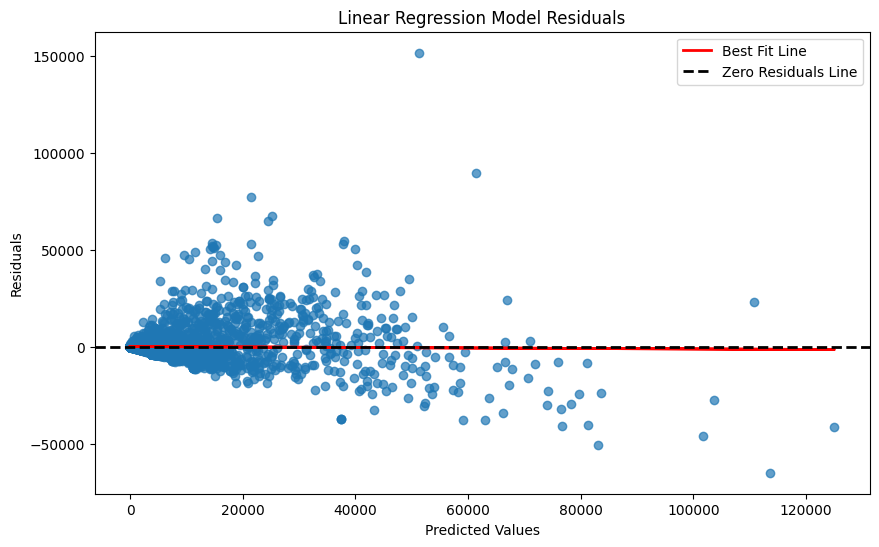

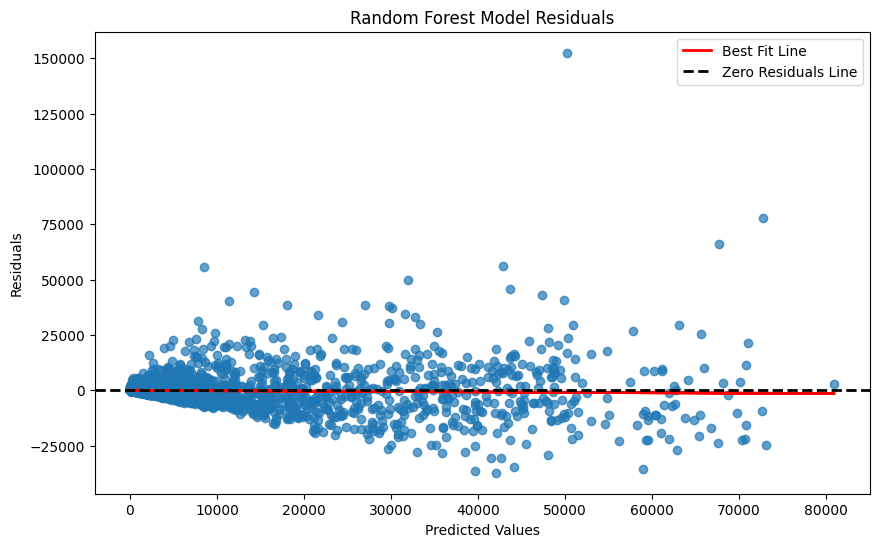

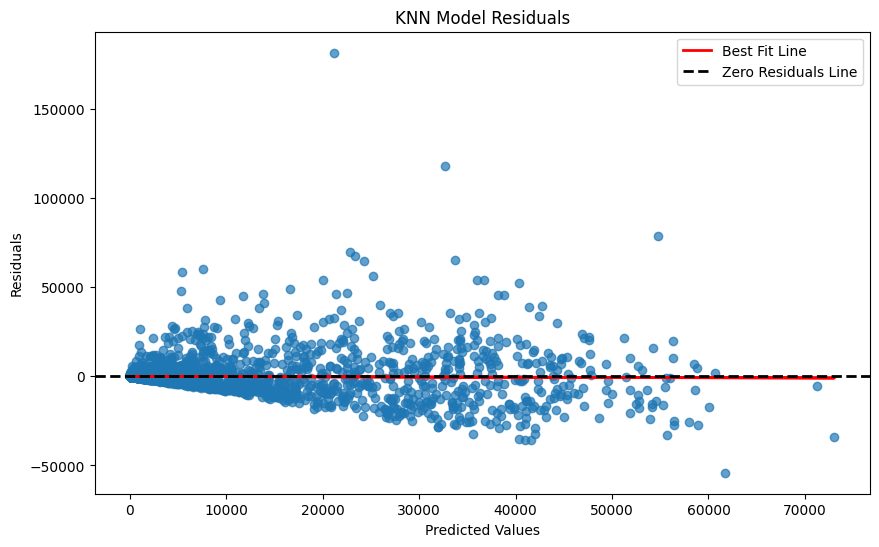

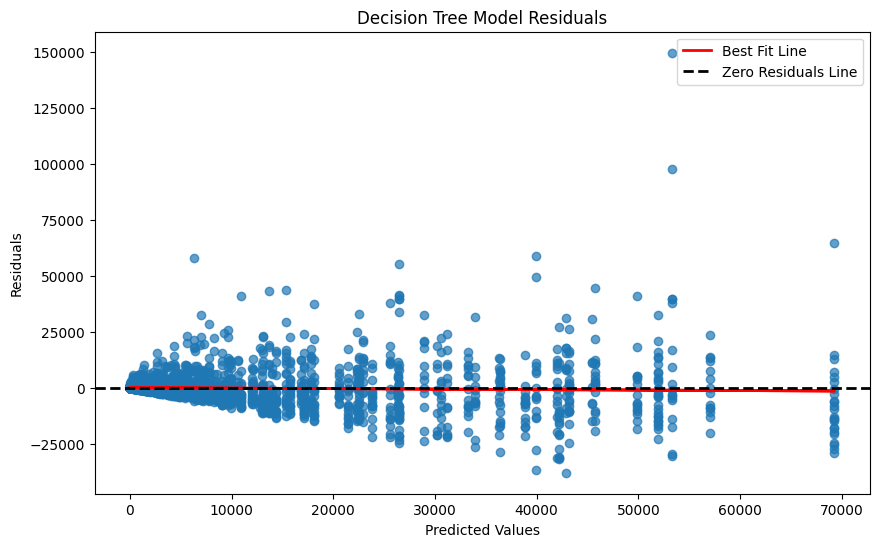

In [14]:
def plot_residuals(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    residuals = y_test - predictions

    lr_residuals = LinearRegression()
    lr_residuals.fit(predictions.reshape(-1, 1), residuals)
    best_fit_line = lr_residuals.predict(predictions.reshape(-1, 1))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.7)
    plt.plot(predictions, best_fit_line, color='red', linewidth=2, label='Best Fit Line')
    plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Zero Residuals Line')
    plt.title(f'{model_name} Model Residuals')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

# Plot Residuals for each model
plot_residuals(linear_model, X_test, y_test, 'Linear Regression')
plot_residuals(rf_model, X_test, y_test, 'Random Forest')
plot_residuals(knn_model, X_test, y_test, 'KNN')
plot_residuals(best_dt_model, X_test, y_test, 'Decision Tree')

# both median and mean predictions have similar looking plots
# plot_residuals(median_predictions, X_test, y_test, 'Baseline (Median)')
# plot_residuals(mean_predictions, X_test, y_test, 'Baseline (Mean)')